<a href="https://colab.research.google.com/github/kuroemon2509/kanji-recognition/blob/master/colab_train_classifier_with_ETL_9B_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train handwriting classifier with [ETLCB](http://etlcdb.db.aist.go.jp/) dataset.

**Remember to set runtime to GPU**

In [1]:
# install some packages that do not come with Colab
!pip install bitstring
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.7MB 67kB/s 
     |████████████████████████████████| 450kB 49.0MB/s 
     |████████████████████████████████| 4.1MB 37.1MB/s 
     |████████████████████████████████| 61kB 25.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum


In [0]:
import os
import time
import math
import re
import shutil
import struct
import traceback
import codecs
import base64
import random
import datetime

from tqdm import tqdm
import bitstring

import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import IPython.display as display

## Grab the ETL-9B dataset.

Head over to the [download page](http://etlcdb.db.aist.go.jp/obtaining-etl-character-database) and fill out the form and you will get the link and password to download the dataset.

After that you can either upload them to Google Colab using the tab on the left (just drop them there) or upload to Google Drive (for private use only because you are not allowed to shared third parties download URLs).

### If you uploaded the dataset to Google Drive then follow these below steps to copy it to the current working directory.

In [0]:
from google.colab import drive

mount_dir = '/gdrive'
drive.mount(mount_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Here is the current working directory content.

In [0]:
os.listdir('.')

['.config',
 'conv2d_01_display_grid.png',
 'maxpool2d_02_display_grid.png',
 'ETL9B_DATASET',
 'JIS0208.py',
 'conv2d_02_display_grid.png',
 'maxpool2d_01_display_grid.png',
 '__pycache__',
 'conv2d_03_display_grid.png',
 'etlcb_9b_labels.txt',
 'maxpool2d_03_display_grid.png',
 'sample_data']

In [0]:
os.listdir(mount_dir)

['My Drive', '.Trash']

In [0]:
res_dir = f'{mount_dir}/My Drive/train_classifier_with_ETL9B'
os.path.exists(res_dir)

True

In [0]:
os.listdir(res_dir)

['ETL9B_DATASET',
 'JIS0208.py',
 'logs',
 'etlcb_9b_labels.txt',
 'kanji_model_weights',
 'kanji_model',
 'train_classifier.ipynb']

In [0]:
jis_filepath = f'{res_dir}/JIS0208.py'
os.path.exists(jis_filepath)

True

In [0]:
shutil.copy(jis_filepath, '.')
os.listdir('.')

['.config', 'JIS0208.py', 'sample_data']

In [0]:
from JIS0208 import JIS0208 as jis2unicode

In [0]:
type(jis2unicode)

dict

In [0]:
dataset_filepath = f'{res_dir}/ETL9B_DATASET'
os.path.exists(dataset_filepath)

True

In [0]:
try:
    shutil.copytree(dataset_filepath, 'ETL9B_DATASET')
except FileExistsError:
    pass

os.listdir('.')

['.config', 'ETL9B_DATASET', 'JIS0208.py', '__pycache__', 'sample_data']

In [0]:
new_dataset_filepath = 'ETL9B_DATASET'
os.path.exists(new_dataset_filepath)

True

In [0]:
os.listdir(new_dataset_filepath)

['ETL9B_5', 'ETL9B_1', 'ETL9B_4', 'ETL9B_3', 'ETL9B_2']

In [0]:
file_list = [
    f'{new_dataset_filepath}/ETL9B_1',
    f'{new_dataset_filepath}/ETL9B_2',
    f'{new_dataset_filepath}/ETL9B_3',
    f'{new_dataset_filepath}/ETL9B_4',
    f'{new_dataset_filepath}/ETL9B_5',
]
file_list

['ETL9B_DATASET/ETL9B_1',
 'ETL9B_DATASET/ETL9B_2',
 'ETL9B_DATASET/ETL9B_3',
 'ETL9B_DATASET/ETL9B_4',
 'ETL9B_DATASET/ETL9B_5']

In [0]:
for ds_filepath in file_list:
    print(os.path.exists(ds_filepath), ds_filepath)

True ETL9B_DATASET/ETL9B_1
True ETL9B_DATASET/ETL9B_2
True ETL9B_DATASET/ETL9B_3
True ETL9B_DATASET/ETL9B_4
True ETL9B_DATASET/ETL9B_5


In [0]:
# filename = file_list[0]
# print(filename)

ETL9B_DATASET/ETL9B_1


In [0]:
# file_stream = bitstring.ConstBitStream(filename=filename)

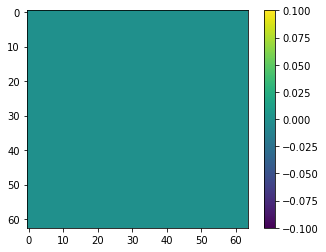

In [0]:
# record = file_stream.readlist('int:16,uint:16,uint:32,bytes:504,pad:512')
# record_dict = {
#     'sheet_number': record[0], # type: int - Serial Sheet Number
#     'JIS_KANJI_CODE': record[1], # type: binary - JIS Kanji Code (JIS X 0208)
#     'JIS_READING': record[2], # type: ASCII - JIS Typical Reading (e.g. 'AI.M')
#     'image_data': record[3], # type: bytes
# }

# width = 64
# height = 63

# # np_img = np.array(Image.frombytes('1', (width, height), record_dict['image_data'], 'raw'))
# np_img = np.array(Image.frombytes('1', (width, height), record_dict['image_data'], 'raw')).astype(np.uint8)
# plt.imshow(np_img)
# plt.colorbar()

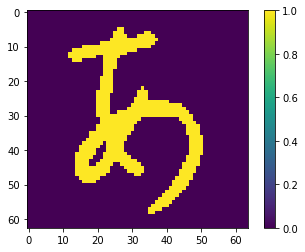

In [0]:
# record = file_stream.readlist('int:16,uint:16,uint:32,bytes:504,pad:512')
# record_dict = {
#     'sheet_number': record[0], # type: int - Serial Sheet Number
#     'JIS_KANJI_CODE': record[1], # type: binary - JIS Kanji Code (JIS X 0208)
#     'JIS_READING': record[2], # type: ASCII - JIS Typical Reading (e.g. 'AI.M')
#     'image_data': record[3], # type: bytes
# }

# width = 64
# height = 63

# np_img = np.array(Image.frombytes('1', (width, height), record_dict['image_data'], 'raw')).astype(np.uint8)
# plt.imshow(np_img)
# plt.colorbar()

In [0]:
# np_img.max(), np_img.min(), np_img.dtype

(1, 0, dtype('uint8'))

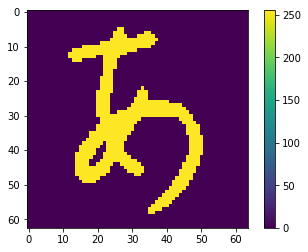

In [0]:
# np_img  = np_img * 255
# plt.imshow(np_img)
# plt.colorbar()

In [0]:
# np_img = cv2.resize(np_img, dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
# plt.imshow(np_img)
# plt.colorbar()

In [0]:
# np_img.shape

(64, 64)

In [0]:
# np_img.dtype

dtype('uint8')

In [0]:
# np_img = np_img.astype(np.float32)
# np_img.dtype

dtype('float32')

In [0]:
# plt.imshow(np_img)
# plt.colorbar()

In [0]:
# np_img = np.array([np_img])
# np_img.shape

(1, 64, 64)

In [0]:
# np.array([np_img]).shape

(1, 1, 64, 64)

In [0]:
# jis = hex(record_dict['JIS_KANJI_CODE'])
# jis

'0x2422'

In [0]:
# jis2unicode[jis]

'0x3042'

In [0]:
# unicode = jis2unicode[jis]
# unicode_value = int(unicode, 0)
# unicode_char = chr(unicode_value)
# unicode_char

'あ'

In [0]:
total_samples = 0
record_count = {}

width = 64
height = 63

all_images = []
all_labels = []

for filename in tqdm(file_list):

    file_stream = bitstring.ConstBitStream(filename=filename)
    # skip the first record in each file
    file_stream.readlist('bytes:576')

    while True:
        try:
            record = file_stream.readlist('int:16,int:16,uint:32,bytes:504,pad:512')
        except:
            break
        
        total_samples += 1
        record_dict = {
            'sheet_number': record[0], # type: int - Serial Sheet Number
            'JIS_KANJI_CODE': record[1], # type: binary - JIS Kanji Code (JIS X 0208)
            'JIS_READING': record[2], # type: ASCII - JIS Typical Reading (e.g. 'AI.M')
            'image_data': record[3], # type: bytes
        }
        np_img = np.array(Image.frombytes('1', (width, height), record_dict['image_data'], 'raw')).astype(np.uint8)
        # np_img  = np_img * 255
        np_img = cv2.resize(np_img, dsize=(64, 64), interpolation=cv2.INTER_NEAREST)
#         np_img = np_img.astype(np.float32)
#         np_img = np.array([np_img])
        np_img = np.reshape(np_img, (64, 64, 1))
        all_images.append(np_img)

        jis_code = hex(record_dict['JIS_KANJI_CODE'])
        unicode = jis2unicode[jis_code]
        unicode_value = int(unicode, 0)
        unicode_char = chr(unicode_value)
        all_labels.append(unicode_char)
        if unicode_char in record_count.keys():
            record_count[unicode_char] += 1
        else:
            record_count[unicode_char] = 1

total_samples

100%|██████████| 5/5 [00:43<00:00,  8.67s/it]


610236

In [0]:
# all_images = np.array(all_images, dtype=np.uint8)
# all_images.shape

(610236, 64, 64, 1)

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam

In [0]:
# all_image_tensors = tf.convert_to_tensor(all_images)

In [0]:
# all_image_tensors.dtype

tf.uint8

In [0]:
# all_image_tensors.get_shape()

TensorShape([610236, 64, 64, 1])

In [0]:
# dataset_size = all_images.size * all_images.itemsize / 1024**3 # GB
# dataset_size

2.3278656005859375

In [0]:
label_list = list(record_count.keys())
len(label_list)

3036

In [0]:
print(label_list[:100])

['あ', 'い', 'う', 'え', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'や', 'ゆ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'わ', 'を', 'ん', '亜', '唖', '娃', '阿', '哀', '愛', '挨', '姶', '逢', '葵', '茜', '穐', '悪', '握', '渥', '旭', '葦', '芦', '鯵', '梓', '圧', '斡', '扱', '宛', '姐', '虻', '飴', '絢', '綾']


In [0]:
label_list.sort()

In [0]:
print(label_list[:100])

['あ', 'い', 'う', 'え', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'や', 'ゆ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'わ', 'を', 'ん', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丑', '且', '世', '丘', '丙', '丞', '両', '並', '中', '串', '丸', '丹', '主', '乃', '久', '之', '乍', '乎', '乏']


Generate label file for reference later.

In [0]:
label_fname = 'etlcb_9b_labels.txt'
with open(label_fname, mode='w', encoding='utf-8') as out:
    for label in label_list:
        out.write(label)
        out.write('\n')

os.listdir('.')

['.config',
 'ETL9B_DATASET',
 'JIS0208.py',
 '__pycache__',
 'etlcb_9b_labels.txt',
 'sample_data']

Copy to Google Drive.

In [0]:
try:
    shutil.copy(label_fname, res_dir)
except:
    pass
os.listdir(res_dir)

['ETL9B_DATASET',
 'JIS0208.py',
 'logs',
 'kanji_model_weights',
 'kanji_model',
 'etlcb_9b_labels.txt',
 'train_classifier.ipynb']

Create char to index dictionary.

In [0]:
char2idx = {c: idx for idx, c in enumerate(label_list)}
print(char2idx)

{'あ': 0, 'い': 1, 'う': 2, 'え': 3, 'お': 4, 'か': 5, 'が': 6, 'き': 7, 'ぎ': 8, 'く': 9, 'ぐ': 10, 'け': 11, 'げ': 12, 'こ': 13, 'ご': 14, 'さ': 15, 'ざ': 16, 'し': 17, 'じ': 18, 'す': 19, 'ず': 20, 'せ': 21, 'ぜ': 22, 'そ': 23, 'ぞ': 24, 'た': 25, 'だ': 26, 'ち': 27, 'ぢ': 28, 'つ': 29, 'づ': 30, 'て': 31, 'で': 32, 'と': 33, 'ど': 34, 'な': 35, 'に': 36, 'ぬ': 37, 'ね': 38, 'の': 39, 'は': 40, 'ば': 41, 'ぱ': 42, 'ひ': 43, 'び': 44, 'ぴ': 45, 'ふ': 46, 'ぶ': 47, 'ぷ': 48, 'へ': 49, 'べ': 50, 'ぺ': 51, 'ほ': 52, 'ぼ': 53, 'ぽ': 54, 'ま': 55, 'み': 56, 'む': 57, 'め': 58, 'も': 59, 'や': 60, 'ゆ': 61, 'よ': 62, 'ら': 63, 'り': 64, 'る': 65, 'れ': 66, 'ろ': 67, 'わ': 68, 'を': 69, 'ん': 70, '一': 71, '丁': 72, '七': 73, '万': 74, '丈': 75, '三': 76, '上': 77, '下': 78, '不': 79, '与': 80, '丑': 81, '且': 82, '世': 83, '丘': 84, '丙': 85, '丞': 86, '両': 87, '並': 88, '中': 89, '串': 90, '丸': 91, '丹': 92, '主': 93, '乃': 94, '久': 95, '之': 96, '乍': 97, '乎': 98, '乏': 99, '乗': 100, '乙': 101, '九': 102, '乞': 103, '也': 104, '乱': 105, '乳': 106, '乾': 107, '亀': 108, '了': 109, '予': 110,

In [0]:
all_idx_labels = [char2idx[c] for c in all_labels]
print(all_idx_labels[:32])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [0]:
all_idx_labels = np.array(all_idx_labels)
# label_tensors = tf.convert_to_tensor(all_idx_labels)
# print(label_tensors.get_shape())

In [0]:
val_split = 0.2

avg_sample_count = None

for k, v in record_count.items():
    if avg_sample_count is None:
        avg_sample_count = v
    else:
        avg_sample_count =(avg_sample_count + v) / 2

print('avg_sample_count:', avg_sample_count)

avg_sample_count: 201.0


In [0]:
val_count = avg_sample_count * val_split
val_count

40.2

In [0]:
val_dict = {idx: 0 for idx in range(len(label_list))}

train_images = []
train_labels = []

val_images = []
val_labels = []

for idx, label in enumerate(all_idx_labels):
    if val_dict[label] < val_count:
        val_dict[label] += 1
        val_images.append(all_images[idx])
        val_labels.append(all_idx_labels[idx])
    else:
        train_images.append(all_images[idx])
        train_labels.append(all_idx_labels[idx])

In [0]:
len(train_images), len(train_labels), len(val_images), len(val_labels)

(485760, 485760, 124476, 124476)

In [0]:
train_images = np.array(train_images, dtype=np.uint8)
train_labels = np.array(train_labels, dtype=np.uint8)

val_images = np.array(val_images, dtype=np.uint8)
val_labels = np.array(val_labels, dtype=np.uint8)

train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

((485760, 64, 64, 1), (485760,), (124476, 64, 64, 1), (124476,))

Load trained model (optional)

In [0]:
# model_filename = os.path.join(res_dir,'kanji_model', '20190723-131113', 'kanji_model.h5')
# model_filename

'/gdrive/My Drive/train_classifier_with_ETL9B/kanji_model/20190723-131113/kanji_model.h5'

In [0]:
# os.path.exists(model_filename)

True

In [0]:
# model = keras.models.load_model(model_filename)
# model.summary()

Model: "Seq_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01 (Conv2D)           (None, 32, 60, 60)        832       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 32, 26, 26)        25632     
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 64, 9, 9)          51264     
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_01 (Flatten)         (None, 1024)              0    

In [0]:
model = Sequential(layers=[
    Conv2D(
        name='conv2d_01',
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(64,64,1,),
        data_format='channels_last',
    ),
    MaxPool2D(
        name='maxpool2d_01',
        pool_size=2,
    ),
    Conv2D(
        name='conv2d_02',
        filters=32,
        kernel_size=5,
        activation='relu',
    ),
    MaxPool2D(
        name='maxpool2d_02',
        pool_size=2,
    ),
    Conv2D(
        name='conv2d_03',
        filters=64,
        kernel_size=5,
        activation='relu',
    ),
    MaxPool2D(
        name='maxpool2d_03',
        pool_size=2,
    ),
    Flatten(name='flatten_01'),
    Dense(
        name='dense_01',
        units=256,
        activation='relu',
    ),
    Dense(
        name='dense_output',
        units=len(label_list),
        activation='softmax',
    ),
], name='Seq_01')

model.summary()

Model: "Seq_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01 (Conv2D)           (None, 60, 60, 32)        832       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 9, 9, 64)          51264     
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_01 (Flatten)         (None, 1024)              0    

In [0]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%tensorboard --logdir "/gdrive/My Drive/train_classifier_with_ETL9B/logs"

Reusing TensorBoard on port 6006 (pid 1438), started 0:15:33 ago. (Use '!kill 1438' to kill it.)

In [0]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, save_dir):
        self.save_dir = save_dir
        
    def time_now(self):
        x = datetime.datetime.now()
        retval = f'{x.year:04d}{x.month:02d}{x.day:02d}_{x.hour:02d}{x.minute:02d}{x.second:02d}'
        return retval
    
    def on_epoch_end(self, epoch, logs={}):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        
        log_list = []
        for k, v in logs.items():
            v_str = f'{v:.4f}'
            log_list.extend([k, v_str])

        log_info = '_'.join(log_list)
        weights_filepath = os.path.join(self.save_dir, f'{self.time_now()}_weights_epoch_{epoch}_{log_info}.h5')
        self.model.save_weights(weights_filepath)

Train model with validation data.

In [0]:
def train_model(batch_size=64, epochs=4):
    print('batch_size:', batch_size)
    logdir = os.path.join(res_dir, 'logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    save_dir = os.path.join(res_dir, 'kanji_model_with_validation', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    my_callback = MyCallback(save_dir=save_dir)
    

    train_history = model.fit(
        x=train_images,
        y=train_labels,
        validation_data=(val_images, val_labels),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=[tensorboard_callback, my_callback],
    )
    model_filepath = os.path.join(save_dir, 'kanji_model.h5')
    model.save(model_filepath)

In [0]:
history = train_model(512, 16)

batch_size: 512
Train on 485760 samples, validate on 124476 samples
Epoch 1/16
485760/485760 [==============================] - 53s 108us/sample - loss: 3.7961 - accuracy: 0.2295 - val_loss: 1.6889 - val_accuracy: 0.5728
Epoch 2/16
485760/485760 [==============================] - 52s 106us/sample - loss: 1.2365 - accuracy: 0.6820 - val_loss: 0.8668 - val_accuracy: 0.7715
Epoch 3/16
485760/485760 [==============================] - 52s 107us/sample - loss: 0.7540 - accuracy: 0.7999 - val_loss: 0.6677 - val_accuracy: 0.8221
Epoch 4/16
485760/485760 [==============================] - 52s 107us/sample - loss: 0.5684 - accuracy: 0.8462 - val_loss: 0.5782 - val_accuracy: 0.8451
Epoch 5/16
485760/485760 [==============================] - 51s 106us/sample - loss: 0.4661 - accuracy: 0.8722 - val_loss: 0.5111 - val_accuracy: 0.8630
Epoch 6/16
485760/485760 [==============================] - 52s 106us/sample - loss: 0.3965 - accuracy: 0.8896 - val_loss: 0.4807 - val_accuracy: 0.8724
Epoch 7/16
485

Train model without validation data.

In [0]:
def train_model(batch_size=64, epochs=4):
    print('batch_size:', batch_size)
    logdir = os.path.join(res_dir, 'logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    save_dir = os.path.join(res_dir, 'kanji_model', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    my_callback = MyCallback(save_dir=save_dir)
    

    train_history = model.fit(
        x=all_image_tensors,
        y=label_tensors,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=[tensorboard_callback, my_callback],
    )
    model_filepath = os.path.join(save_dir, 'kanji_model.h5')
    model.save(model_filepath)

In [0]:
# train_model(512, 4)
train_model(512, 20)

batch_size: 512


W0723 22:58:34.391410 140112874489728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0723 22:58:34.492821 140112874489728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 610236 samples
Epoch 1/20
   512/610236 [..............................] - ETA: 1:38:25 - loss: 8.0177 - accuracy: 0.0000e+00

W0723 22:58:39.727328 140112874489728 callbacks.py:242] Method (on_train_batch_end) is slow compared to the batch update (0.232063). Check your callbacks.


610236/610236 [==============================] - 63s 104us/sample - loss: 1.8935 - accuracy: 0.6328
Epoch 2/20
610236/610236 [==============================] - 59s 97us/sample - loss: 0.3075 - accuracy: 0.9136
Epoch 3/20
610236/610236 [==============================] - 59s 96us/sample - loss: 0.1862 - accuracy: 0.9459
Epoch 4/20
610236/610236 [==============================] - 59s 97us/sample - loss: 0.1375 - accuracy: 0.9587
Epoch 5/20
610236/610236 [==============================] - 59s 97us/sample - loss: 0.1093 - accuracy: 0.9664
Epoch 6/20
610236/610236 [==============================] - 59s 96us/sample - loss: 0.0889 - accuracy: 0.9724
Epoch 7/20
610236/610236 [==============================] - 59s 97us/sample - loss: 0.0770 - accuracy: 0.9759
Epoch 8/20
610236/610236 [==============================] - 59s 96us/sample - loss: 0.0662 - accuracy: 0.9791
Epoch 9/20
610236/610236 [==============================] - 59s 97us/sample - loss: 0.0593 - accuracy: 0.9811
Epoch 10/20
610236/6

## Convert keras model to tflite

In [0]:
model_filename = '20_epochs_kanji_model.h5'
model = keras.models.load_model(model_filename)
model.summary()

Model: "Seq_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01 (Conv2D)           (None, 60, 60, 32)        832       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 26, 26, 32)        25632     
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 9, 9, 64)          51264     
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_01 (Flatten)         (None, 1024)              0    

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = converter.convert()

In [0]:
tflite_filename = 'etlcb_9b_model.tflite'
open(tflite_filename, 'wb').write(tflite)

4484348

In [0]:
results = model.predict(all_images)
type(results)

numpy.ndarray

In [0]:
results.shape

(610236, 3036)

In [0]:
results_idx = np.argmax(results, axis=1)
results_idx.shape

(610236,)

In [0]:
result_loss = {c: 0 for c in label_list}
result_accuracy = {c: 0 for c in label_list}
for i in range(len(results_idx)):
    c = label_list[results_idx[i]]
    if results_idx[i] == all_idx_labels[i]:
        result_accuracy[c] += 1
    else:
        result_loss[c] += 1

In [0]:
result_loss

{'あ': 1,
 'い': 0,
 'う': 4,
 'え': 11,
 'お': 0,
 'か': 1,
 'が': 0,
 'き': 0,
 'ぎ': 2,
 'く': 0,
 'ぐ': 0,
 'け': 0,
 'げ': 0,
 'こ': 4,
 'ご': 4,
 'さ': 24,
 'ざ': 1,
 'し': 1,
 'じ': 1,
 'す': 0,
 'ず': 34,
 'せ': 0,
 'ぜ': 3,
 'そ': 6,
 'ぞ': 0,
 'た': 2,
 'だ': 0,
 'ち': 0,
 'ぢ': 0,
 'つ': 4,
 'づ': 0,
 'て': 2,
 'で': 3,
 'と': 0,
 'ど': 0,
 'な': 2,
 'に': 2,
 'ぬ': 1,
 'ね': 0,
 'の': 7,
 'は': 1,
 'ば': 14,
 'ぱ': 3,
 'ひ': 18,
 'び': 1,
 'ぴ': 5,
 'ふ': 2,
 'ぶ': 3,
 'ぷ': 0,
 'へ': 0,
 'べ': 1,
 'ぺ': 0,
 'ほ': 0,
 'ぼ': 4,
 'ぽ': 0,
 'ま': 4,
 'み': 0,
 'む': 0,
 'め': 1,
 'も': 0,
 'や': 0,
 'ゆ': 0,
 'よ': 1,
 'ら': 2,
 'り': 3,
 'る': 0,
 'れ': 0,
 'ろ': 6,
 'わ': 1,
 'を': 0,
 'ん': 0,
 '一': 0,
 '丁': 0,
 '七': 1,
 '万': 7,
 '丈': 0,
 '三': 0,
 '上': 0,
 '下': 0,
 '不': 1,
 '与': 0,
 '丑': 0,
 '且': 0,
 '世': 0,
 '丘': 0,
 '丙': 0,
 '丞': 0,
 '両': 5,
 '並': 1,
 '中': 0,
 '串': 1,
 '丸': 11,
 '丹': 0,
 '主': 0,
 '乃': 2,
 '久': 0,
 '之': 18,
 '乍': 0,
 '乎': 21,
 '乏': 0,
 '乗': 10,
 '乙': 0,
 '九': 1,
 '乞': 3,
 '也': 4,
 '乱': 0,
 '乳': 0,
 '乾': 0,
 '亀': 0,
 '了': 0,
 

In [0]:
model.layers

In [0]:
layer_outputs = [layer.output for layer in model.layers[:6]]
layer_outputs

[<tf.Tensor 'conv2d_01_2/Identity:0' shape=(None, 32, 60, 60) dtype=float32>,
 <tf.Tensor 'maxpool2d_01_2/Identity:0' shape=(None, 32, 30, 30) dtype=float32>,
 <tf.Tensor 'conv2d_02_2/Identity:0' shape=(None, 32, 26, 26) dtype=float32>,
 <tf.Tensor 'maxpool2d_02_2/Identity:0' shape=(None, 32, 13, 13) dtype=float32>,
 <tf.Tensor 'conv2d_03_2/Identity:0' shape=(None, 64, 9, 9) dtype=float32>,
 <tf.Tensor 'maxpool2d_03_2/Identity:0' shape=(None, 64, 4, 4) dtype=float32>]

In [0]:
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_01_input (InputLayer) [(None, 1, 64, 64)]       0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 32, 60, 60)        832       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 32, 26, 26)        25632     
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 32, 13, 13)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 64, 9, 9)          51264     
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 64, 4, 4)          0     

In [0]:
def visualize_layers(x):
    
    activations = activation_model.predict(x)
    
    layer_names = []
    for layer in model.layers[:6]:
        layer_names.append(layer.name)

    images_per_row = 16

    for idx, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)): # displays the feature maps
        # feature map has shape(1, n_features, height, width)
        n_features = layer_activation.shape[1]
        h, w = layer_activation.shape[2:4]

        n_rows = math.ceil(n_features / images_per_row) # tiles the activation channels in this matrix
        display_grid = np.zeros(shape=(h*n_rows, w * images_per_row))
        for row in range(n_rows):
            for col in range(images_per_row):
                channel_image = layer_activation[0, row * images_per_row + col, :, :]
                # post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype(np.uint8)

                # displays the grid
                display_grid[
                    row * h: (row + 1) * h, 
                    col * w: (col + 1) * w
                ] = channel_image

        fig_fname = f'{layer_name}_display_grid.png'
        plt.imsave(fig_fname, display_grid, cmap='viridis')
        display.display(display.HTML(layer_name))

        encoded_string = base64.b64encode(open(fig_fname, mode='rb').read())
        encoded_string = str(encoded_string, encoding='utf-8')
        img_html = f'<img style="width: 100%;image-rendering: pixelated;" src="data:image/png;base64,{encoded_string}">'
        display.display(display.HTML(img_html))

In [0]:
idx = random.randrange(all_images.shape[0])
idx

479191

聞


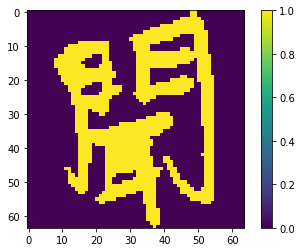

In [0]:
print(all_labels[idx])
np_img = all_images[idx]
img = np_img[0]
plt.imshow(img)
plt.colorbar()

In [0]:
char2idx[all_labels[idx]]

2158

(1, 1, 64, 64)
2158
聞


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide



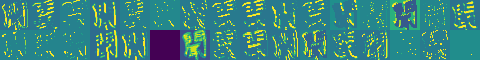


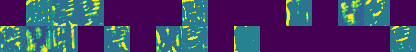


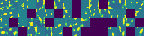

In [0]:
x = np.array([np_img])
print(x.shape)
predicted_idx = np.argmax(model.predict(x)[0])
print(predicted_idx)
predicted_char = label_list[predicted_idx]
print(predicted_char)
visualize_layers(x)

In [0]:
tflite_filename = 'etlcb_9b_model.tflite'

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [0]:
tflite_model = converter.convert()

ConverterError: ignored